In [14]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
from matplotlib import ticker, cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob

In [2]:
def get_fes(bins, val):
    F = []
    s = []
    mesh = (bins[1] - bins[0])/2
    i = 0
    min = -kT * math.log(val[0])

    while val[i] != 0 and i<len(val)-1:
        F.append(-kT * math.log(val[i]))
        s.append(bins[i] + mesh)
        if F[i] < min:
            min = F[i]
        i = i + 1

    # Remove the offset
    F = F - min*np.ones(len(F))
    return F, s

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2201/3992394973.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  MetaD = plumed.read_as_pandas("data/metad_data.dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2201/3992394973.py:2: UserWarning: cannot load PLUMED instance, conversions will not be available
  Funnel = plumed.read_as_pandas("data/Ca_EF2_funnel.dat")


Text(0, 0.5, 'Probability density')

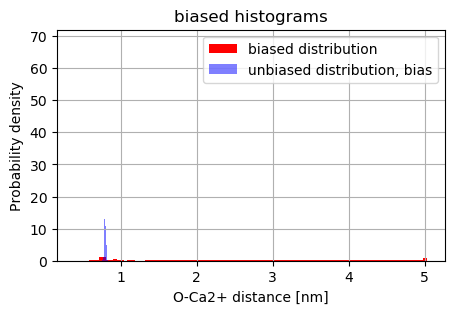

In [3]:
MetaD = plumed.read_as_pandas("data/metad_data.dat")
Funnel = plumed.read_as_pandas("data/Ca_EF2_funnel.dat")
plt.rcParams["figure.figsize"] = (5, 3)

MetaD_eq = MetaD.iloc[600000:]
Funnel_eq = Funnel.iloc[600000:]
merged_data = pd.merge(Funnel_eq, MetaD_eq, on="time")
selected_columns = merged_data[['fps.lp', 'metad.rbias']]

val_bias, bins_bias, patches_bias = plt.hist(selected_columns["fps.lp"], bins=100, density=True, color='r', label="biased distribution")
kT = 1

w = [math.exp(selected_columns["metad.rbias"][i]/kT) for i in range(len(selected_columns["fps.lp"]))]
val_unbias, bins_unbias, patches_unbias = plt.hist(selected_columns["fps.lp"], bins=500, weights=w, density=True, alpha = 0.5, color= 'b', label="unbiased distribution, bias")
plt.grid()
plt.legend(loc="best")
plt.title("biased histograms")
plt.xlabel("O-Ca2+ distance [nm]")
plt.ylabel("Probability density")
plt.ylim([0, 20])

# Posso riportare anche questo plot, magari facendo uno zoom!

Text(0, 0.5, 'Free energy [kcal/mol]')

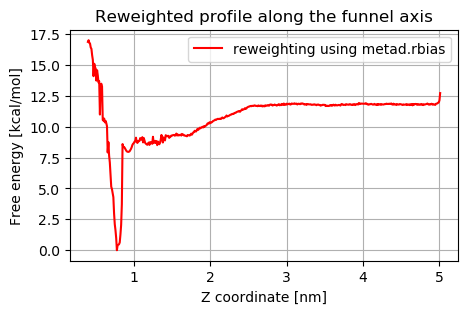

In [5]:
F = []
dist = []
F, dist = get_fes(bins_unbias, val_unbias)
plt.rcParams["figure.figsize"] = (5, 3)

plt.plot(dist, F/4.184, 'r',label="reweighting using metad.rbias")

with open('fes_fps.dat', 'w') as file:
    for item1, item2 in zip(dist, F):
        file.write(f"{item1}\t{item2/4.184}\n")  # Using tab as a separator

plt.grid()
plt.legend(loc="best")
plt.title("Reweighted profile along the funnel axis")
plt.xlabel("Z coordinate [nm]")
plt.ylabel("Free energy [kcal/mol]")

In [3]:
# Number of bootstrap samples
num_bootstrap_samples = 1000

# Specify the range of files to include
fes_files = [f"FES/fes_{i}.dat" for i in range(12, 26)]

# Load the free energy profiles from the specified files
fes_profiles = []

for file in fes_files:
    data = np.loadtxt(file)
    if len(fes_profiles) == 0:
        x_values = data[:, 0]  # the first column is the reaction coordinate
    fes_profiles.append(data[:, 1])  # the second column is the free energy

# Convert list to numpy array
fes_profiles = np.array(fes_profiles)

# Bootstrap sampling
bootstrap_means = []
for _ in range(num_bootstrap_samples):
    #generates a list of 14 indices, chosen randomly with replacement, from the range 0 to 13.
    bootstrap_sample = np.random.choice(fes_profiles.shape[0], size=fes_profiles.shape[0], replace=True)
    # fes_profiles.shape[0] gives the number of original free energy profiles

    #extracts the actual free energy profiles corresponding to the selected indices.
    bootstrap_sample_mean = np.mean(fes_profiles[bootstrap_sample, :], axis=0)
    # it computes the mean of these profiles along the reaction coordinate 
    # (i.e., average each free energy value at each reaction coordinate point across 
    # the sampled profiles).
    
    bootstrap_means.append(bootstrap_sample_mean)

# Convert bootstrap means to numpy array
bootstrap_means = np.array(bootstrap_means)

# Compute mean free energy profile and standard deviation (error bars)
mean_profile = np.mean(bootstrap_means, axis=0)
error_bars = np.std(bootstrap_means, axis=0)
#Computes the standard deviation of the bootstrap mean profiles 
# at each reaction coordinate point, providing an estimate of the error bars.


# Save the results
output_data = np.vstack((x_values, mean_profile, error_bars)).T
np.savetxt("bootstrap_fes.dat", output_data, header="Reaction Coordinate Mean_Free_Energy Error_Bars")

print("Bootstrap analysis completed. Results saved to 'bootstrap_fes.dat'.")


Bootstrap analysis completed. Results saved to 'bootstrap_fes.dat'.


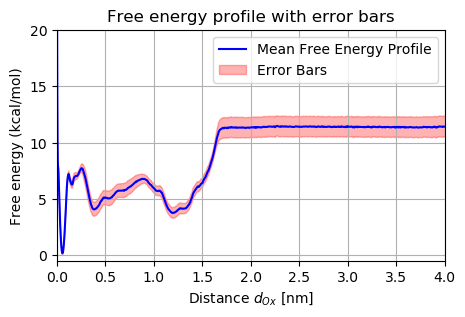

In [32]:
# Load the bootstrap results
data = np.loadtxt("bootstrap_fes.dat")
x_values = data[:, 0]
mean_profile = data[:, 1]
error_bars = data[:, 2]

plt.rcParams["figure.figsize"] = (5, 3)

# Create the plot
step = 50
#plt.errorbar(x_values[::step], mean_profile[::step]/4.184, yerr=error_bars[::step], fmt='o', color='b', ecolor='r', capsize=5, capthick=2, elinewidth=2)
#plt.plot(x_values, mean_profile/4.184, 'b')

plt.plot(x_values, mean_profile/4.184, label="Mean Free Energy Profile", color="blue")
plt.fill_between(x_values, (mean_profile - error_bars)/4.184, (mean_profile + error_bars)/4.184, 
                 color="red", alpha=0.3, label="Error Bars")

# Add labels and title
plt.xlim([0, 4])
plt.ylim([-0.5, 20])
plt.grid()
plt.xlabel(r"Distance $d_{Ox}$ [nm]")
plt.ylabel("Free energy (kcal/mol)")
plt.title("Free energy profile with error bars")
plt.legend()

plt.axvspan(0.01, 0.5, color='yellow', alpha=0.3)
plt.text(0.5, 20, '1st basin', horizontalalignment='center', verticalalignment='center', fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))
plt.axvspan(3.0, 4.0, color='green', alpha=0.3)
plt.text(3.5, 20, 'unbound state', horizontalalignment='center', verticalalignment='center', fontsize=12, bbox=dict(facecolor='green', alpha=0.5))

# Save the plot to a file
#plt.savefig("pics/free_energy_errorbar.png")


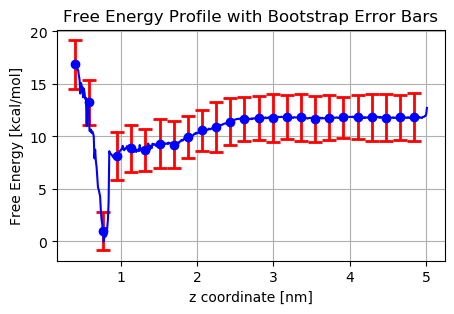

In [23]:
# Generate Bootstrap Samples
# Assuming you have n data points (distances and corresponding free energies), 
# you can create N bootstrap samples

# Number of bootstrap samples
N = 500

# Function to generate bootstrap samples
def generate_bootstrap_samples(data, N):
    n = len(data)
    bootstrap_samples = np.random.choice(data, (N, n), replace=True)
    return bootstrap_samples

bootstrap_samples = generate_bootstrap_samples(F/4.184, N)

# Calculate the standard deviation of the bootstrap samples
errors = np.std(bootstrap_samples, axis=0)

# Combine distance points, free energies, and errors for better visualization
free_energy_with_errors = list(zip(dist, F/4.184, errors))

step = 20
plt.rcParams["figure.figsize"] = (5, 3)
plt.errorbar(dist[::step], F[::step]/4.184, yerr=errors[::step], fmt='o', color='b', ecolor='r', capsize=5, capthick=2, elinewidth=2)
plt.plot(dist, F/4.184, 'b')
plt.title('Free Energy Profile with Bootstrap Error Bars')
plt.xlabel('z coordinate [nm]')
plt.ylabel('Free Energy [kcal/mol]')
plt.grid(True)
plt.show()

In [ ]:
# Add inset zoom
# Determine the range for the zoomed-in section
zoom_start = x_values[200]
zoom_end = x_values[int(len(x_values) * 0.3)]  # Adjust the 0.2 as needed to zoom the leftmost part

# Create an inset axis
ax_inset = inset_axes(ax, width="40%", height="30%", loc="lower right")
ax_inset.plot(x_values, mean_profile/4.184, color="blue")
ax_inset.fill_between(x_values, (mean_profile - error_bars)/4.184, (mean_profile + error_bars)/4.184, 
                      color="red", alpha=0.3)
ax_inset.set_xlim(zoom_start, zoom_end)
ax_inset.set_ylim(np.min((mean_profile - error_bars)/4.184), np.max((mean_profile + error_bars)/4.184))